In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import diff_classifier.aws as aws
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.imagej as ij
import diff_classifier.heatmaps as hm

from scipy.spatial import Voronoi
import scipy.stats as stats
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.cm as cm
import os
import os.path as op
import numpy as np
import numpy.ma as ma
import pandas as pd
import boto3
import itertools

In [2]:
radius = [4.5, 6.0, 7.0]
do_median_filtering = [True, False]
quality = [1.5, 4.5, 8.5]
linking_max_distance = [6.0, 10.0, 15.0]
gap_closing_max_distance = [6.0, 10.0, 15.0]
max_frame_gap = [1, 2, 5]
track_displacement = [0.0, 10.0, 20.0]

sweep = [radius, do_median_filtering, quality, linking_max_distance, gap_closing_max_distance, max_frame_gap,
         track_displacement]
all_params = list(itertools.product(*sweep))

In [ ]:
local_folder = '.'
prefix = "P1_S1_R_0001_2_2"
name = "{}.tif".format(prefix)
local_im = op.join(local_folder, name)

outputs = np.zeros((len(all_params), len(all_params[0])+2))

In [ ]:
counter = 50
for i in range(50, len(all_params)):
    params = all_params[i]
    outfile = 'Traj_{}_{}.csv'.format(name.split('.')[0], counter)
    msd_file = 'msd_{}_{}.csv'.format(name.split('.')[0], counter)
    iter_name = "{}_{}".format(prefix, counter)

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=params[0], threshold=0., 
             do_median_filtering=params[1], quality=params[2], x=511, y=511, ylo=1, median_intensity=300.0, snr=0.0, 
             linking_max_distance=params[3], gap_closing_max_distance=params[4], max_frame_gap=params[5],
             track_displacement=params[6])

    traj = ut.csv_to_pd(outfile)
    msds = msd.all_msds2(traj, frames=651)
    msds.to_csv(msd_file)
    gmean1, gSEM1 = hm.plot_individual_msds(iter_name, alpha=0.05)
    print('Successful parameter calculations for {}'.format(iter_name))
    
    outputs[counter, 0:len(params)] = params
    outputs[counter, len(params)] = gmean1[100]
    outputs[counter, len(params)+1] = max(msds['Track_ID'])
    np.savetxt("sensitivity_sweep.csv", outputs, delimiter=",")
    counter = counter+1
    plt.close('all')

In [3]:
s3 = boto3.client('s3')

folder = '01_18_Experiment'
s_folder = '{}/sensitivity'.format(folder)
local_folder = '.'
prefix = "P1_S1_R_0001_2_2"
name = "{}.tif".format(prefix)
local_im = op.join(local_folder, name)
outputs = np.zeros((len(all_params), len(all_params[0])+2))

In [ ]:
for counter in range(0, len(all_params)):
    try:
        params = all_params[counter]
        msd_file = 'msd_{}_{}.csv'.format(name.split('.')[0], counter)
        geo_file = 'geomean_{}_{}.csv'.format(name.split('.')[0], counter)
        geoS_file = 'geoSEM_{}_{}.csv'.format(name.split('.')[0], counter)
        msd_image = 'msds_{}_{}.png'.format(name.split('.')[0], counter)
        iter_name = "{}_{}".format(prefix, counter)

        aws.download_s3('{}/{}'.format(s_folder, msd_file), msd_file)
        aws.download_s3('{}/{}'.format(s_folder, geo_file), geo_file)

        msd = pd.read_csv(msd_file, index_col='Unnamed: 0')
        gmean1 = np.genfromtxt(geo_file)

        outputs[counter, 0:len(params)] = params
        outputs[counter, len(params)] = gmean1[100]
        outputs[counter, len(params)+1] = max(msd['Track_ID'])
        
        os.remove(msd_file)
        os.remove(geo_file)
    except:
        params = all_params[counter]
        print("Missing data ata {}".format(params))

In [ ]:
pd_outputs = pd.DataFrame(data=outputs,
             columns=['radius', 'mean filter', 'quality', 'linking max D', 'gap closing max D', 'max frame gap',
                      'track displacement', 'MSD', 'particles'])

In [ ]:
pd_outputs.to_csv('sensitivity_analysis.csv', sep=",")

In [ ]:
pd_outputs[(pd_outputs['radius']==4.5) &
           (pd_outputs['mean filter']==1.0) &
           (pd_outputs['quality']==4.5) &
           (pd_outputs['linking max D']==10.0) &
           (pd_outputs['gap closing max D']==10.0) &
           (pd_outputs['max frame gap']==2.0)]

In [ ]:
pd_outputs[(pd_outputs['particles']>12000)]

In [8]:
pd_outputs = pd.read_csv('sensitivity_analysis.csv', index_col='Unnamed: 0')

In [4]:
aws.upload_s3('sensitivity_analysis.csv', '{}/sensitivity_analysis.csv'.format(s_folder))

# Parameter Analysis

In [17]:
pd_outputs[(pd_outputs['radius']==4.5) &
     (pd_outputs['mean filter']==1.0) &
     (pd_outputs['quality']==4.5) &
     (pd_outputs['linking max D']==10.0) &
     (pd_outputs['gap closing max D']==10.0) &
     (pd_outputs['max frame gap']==2.0) &
     (pd_outputs['track displacement']==10.0)]

,radius,mean filter,quality,linking max D,gap closing max D,max frame gap,track displacement,MSD,particles
121,4.5,1.0,4.5,10.0,10.0,2.0,10.0,1.810576,1577.0
364,4.5,0.0,4.5,10.0,10.0,2.0,10.0,1.851832,1602.0


In [59]:
#Change in radius
counter = 0
dN = []
dMSD = []
for gapD in gap_closing_max_distance:
    for gap in max_frame_gap:
        for link in linking_max_distance:
            for qua in quality:
                for rad in radius:
                    for disp in track_displacement:
                        currentMSD = pd_outputs[(pd_outputs['radius']==rad) &
                                        
                                         (pd_outputs['quality']==qua) & 
                                         (pd_outputs['linking max D']==link) & 
                                         (pd_outputs['gap closing max D']==gapD) & 
                                         (pd_outputs['max frame gap']==gap) &
                                         (pd_outputs['track displacement']==disp)]['MSD'].as_matrix()
                        dMSD.append((currentMSD[1] - currentMSD[0]))
                        
                        currentN = pd_outputs[(pd_outputs['radius']==rad) &
                                         
                                         (pd_outputs['quality']==qua) & 
                                         (pd_outputs['linking max D']==link) & 
                                         (pd_outputs['gap closing max D']==gapD) & 
                                         (pd_outputs['max frame gap']==gap) &
                                         (pd_outputs['track displacement']==disp)]['particles'].as_matrix()
                        dN.append((currentMSD[1] - currentMSD[0]))
                        
                        counter = counter + 1

np.asarray(dMSD)
print('Mean dMSD is {} +/- {}'.format(np.mean(dMSD), stats.sem(dMSD)))

Mean dMSD is 0.01743665245360274 +/- 0.0012712658645167953


In [5]:
index=['radius', 'quality', 'linking', 'gap D', 'f gap', 'disp', 'filt']
sensitivity = {'Mean': np.array([-0.0240501, -0.059174, 0.0066154, 0.01095, 0.018117, 0, -0.017437]),
               'SEM': np.array([0.000815328, 0.00096908, 0.0005201, 0.0004963, 0.0007438, 0.000004, 0.0012713])}
df = pd.DataFrame(data=sensitivity, index=index)

In [6]:
df

,Mean,SEM
radius,-0.024050,0.000815
quality,-0.059174,0.000969
linking,0.006615,0.000520
gap D,0.010950,0.000496
f gap,0.018117,0.000744
disp,0.000000,0.000004
filt,-0.017437,0.001271


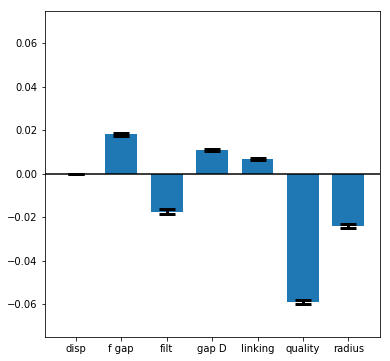

In [8]:
width = 0.7
ra = 0.075
fig = plt.figure(figsize=(6, 6))
p1 = plt.bar(index, df['Mean'], width=width, yerr=df['SEM'], capsize=8, error_kw={'elinewidth':3, 'capthick':3})

plt.axhline(y=0, color='k')
plt.ylim(-ra, ra)
plt.savefig('parameter_sensitivity.png', bbox_inches='tight')

In [9]:
aws.upload_s3('parameter_sensitivity.png', '{}/parameter_sensitivity.png'.format(s_folder))

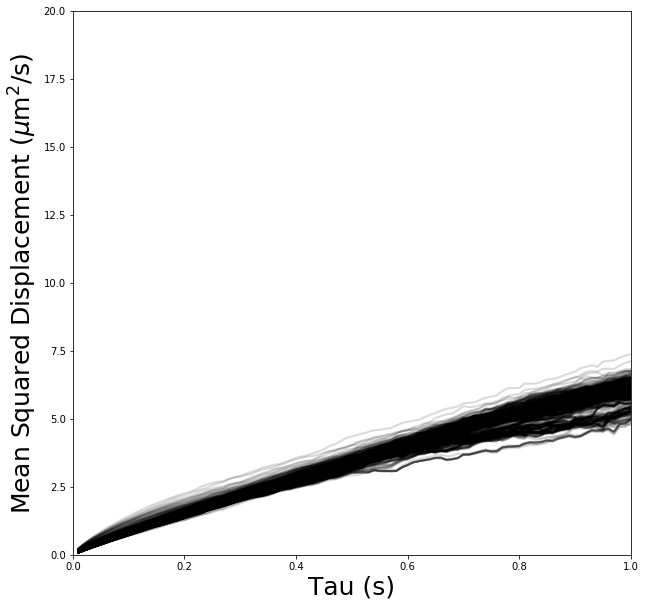

In [12]:
frames = 651
fps = 100.02
t = np.linspace(0, frames-1, frames)/fps

fig = plt.figure(figsize=(10, 10))
for counter in range(0, len(all_params)):
    try:
        geo_file = 'geomean_{}_{}.csv'.format(name.split('.')[0], counter)
        aws.download_s3('{}/{}'.format(s_folder, geo_file), geo_file)
        gmean1 = np.genfromtxt(geo_file)
        os.remove(geo_file)
        
        plt.plot(t, np.exp(gmean1), 'k', linewidth=2, alpha=0.05)
    except:
        params = all_params[counter]
        print("Missing data {}".format(params))

plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$/s)', fontsize=25)
plt.savefig('MSD_sweep.png', bbox_inches='tight')
aws.upload_s3('MSD_sweep.png', '{}/MSD_sweep.png'.format(s_folder))